In [2]:
#import the libraries
!pip install pandas_datareader

import math
import itertools
import pandas_datareader as web
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("fivethirtyeight")

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
#get the stock quote
df = web.DataReader('AAPL', data_source='yahoo',start='2012-01-02', end='2021-12-31')
df.reset_index(inplace=True,drop=False) #set index

In [4]:
df['Date'].min()

Timestamp('2012-01-03 00:00:00')

In [5]:
df.Date = pd.to_datetime(df.Date, format='%Y%m%d', errors='ignore') #remove the time

In [6]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
#df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Date')

## Data Processing

In [7]:
df.isnull().sum() #check for any null value

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [8]:
df = df.groupby('Date')['Close'].sum().reset_index()
df

,Date,Close
0,2012-01-03,14.686786
1,2012-01-04,14.765714
2,2012-01-05,14.929643
3,2012-01-06,15.085714
4,2012-01-09,15.061786
...,...,...
2512,2021-12-27,180.330002
2513,2021-12-28,179.289993
2514,2021-12-29,179.380005
2515,2021-12-30,178.199997


In [9]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=2517, freq=None)

In [10]:
df.index = pd.to_datetime(df.index) 

In [11]:
monthly_mean = df.Close.resample('M').mean() #resample the data by the mean value

In [12]:
monthly_mean['2019']

Date
2019-01-31    38.541548
2019-02-28    42.931973
2019-03-31    45.823453
2019-04-30    50.129048
2019-05-31    47.818409
2019-06-30    48.242250
2019-07-31    51.304091
2019-08-31    51.239432
2019-09-30    54.498750
2019-10-31    58.821630
2019-11-30    65.630126
2019-12-31    69.131428
Freq: M, Name: Close, dtype: float64

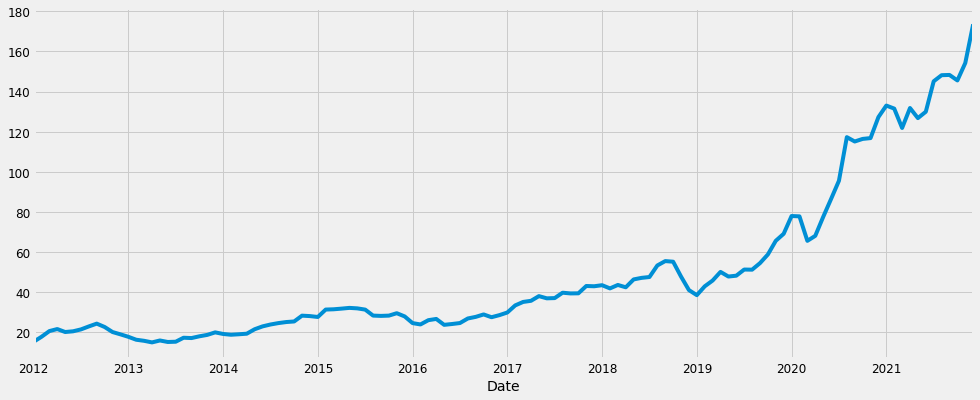

In [13]:
monthly_mean.plot(figsize=(15, 6))
plt.show()

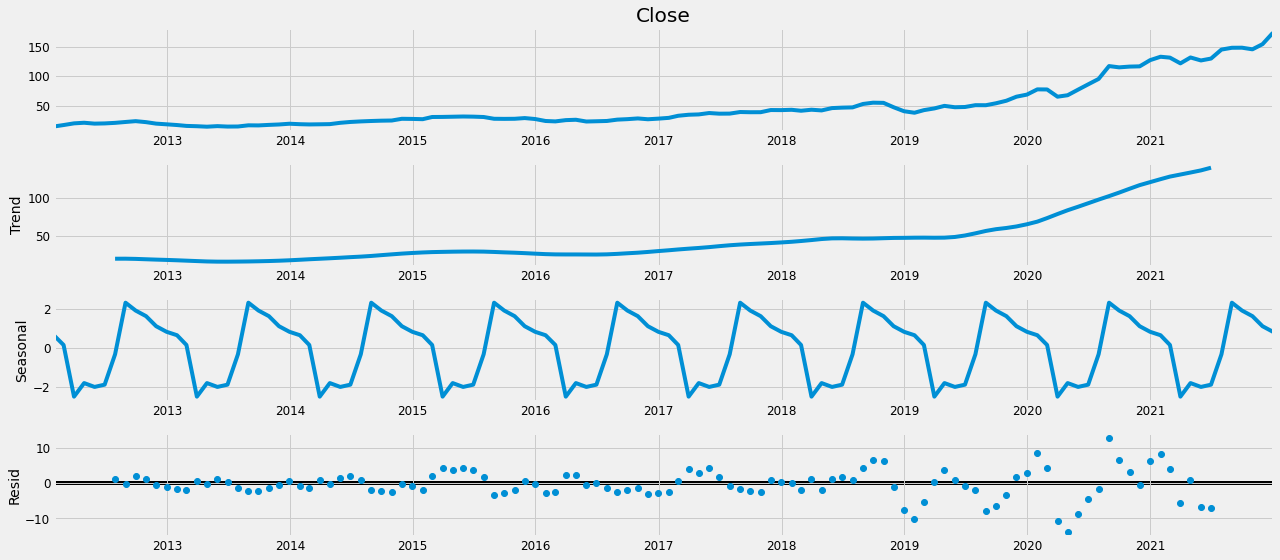

In [14]:
#time-Series decomposition: trend, sesaonality and noise

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

## ARIMA - Autoregressive Integrated Moving Average

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1324.0989468558362
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1116.5446717999782
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:978.7171025061467
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:849.4112595531511
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:888.6413530803899
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:877.4624388563288
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:848.2752954446507
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:815.2840249259866
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1167.721419029585
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:981.1680294523688
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:851.5005909135244
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:750.9417438343385
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:791.6201469796222
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:769.6487938365286
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:758.7453579058592
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:726.3599454616016
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:697.8464113349228
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:635.1833464441473
ARIMA(0,

/Users/hweeli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hweeli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:625.512470952047
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:668.3262661884337
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:574.3480118690941
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:625.4744575815735
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:627.4743420324636
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:567.7188669881081
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:576.3468403494601
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:676.5945428334206


/Users/hweeli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:620.0683481800955
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:662.1781617220406
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:569.4240675929435
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:624.9679279084517
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:621.9935149765951
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:565.765267702413
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:562.642089968771
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:689.420325965116
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:630.4179932715364
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:660.5396644856664
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:570.7242923927569
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:629.4224312483385
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:631.0788579040435
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:561.7179366946484
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:563.4692726033635
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:686.118131698299
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:627.3811454227451
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:657.0386318435692
ARIMA(1, 1, 1)

In [17]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [18]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2752      0.093      2.963      0.003       0.093       0.457
ar.S.L12      -0.8138      0.166     -4.917      0.000      -1.138      -0.489
ma.S.L12       0.1259      0.182      0.692      0.489      -0.231       0.482
sigma2        21.4659      2.499      8.591      0.000      16.569      26.363


/Users/hweeli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


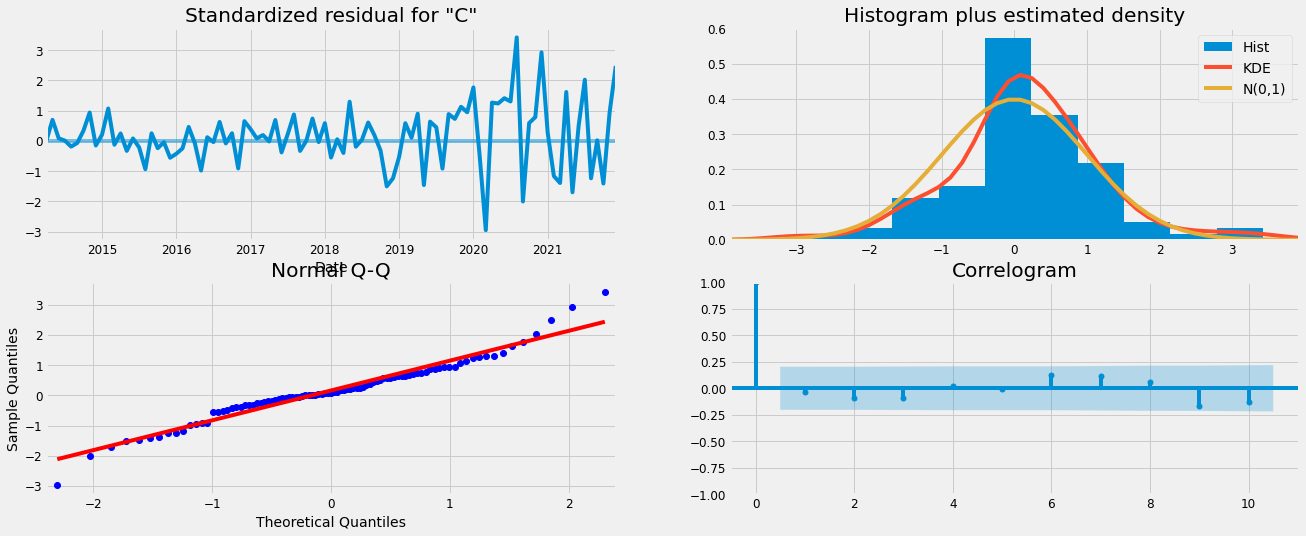

In [19]:
results.plot_diagnostics(figsize=(20,8))
plt.show()

## Validating Forecasts

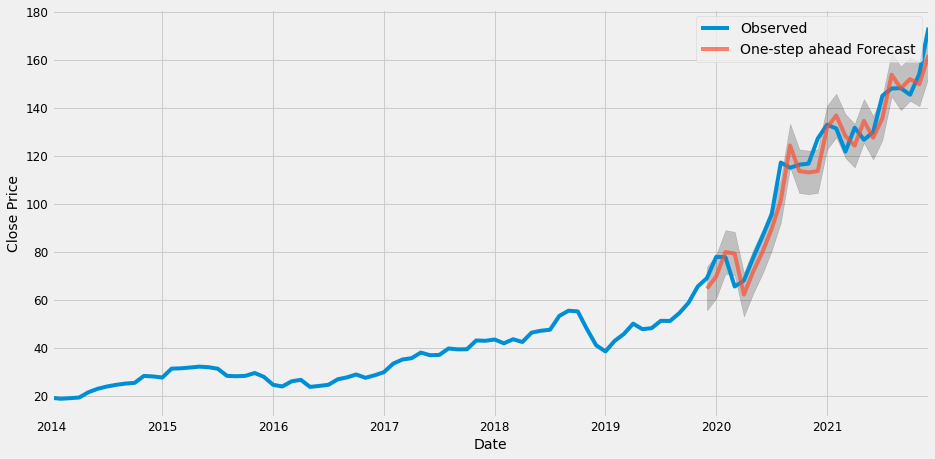

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
plt.legend()

plt.show()

In [21]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 59.09


In [22]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 7.69


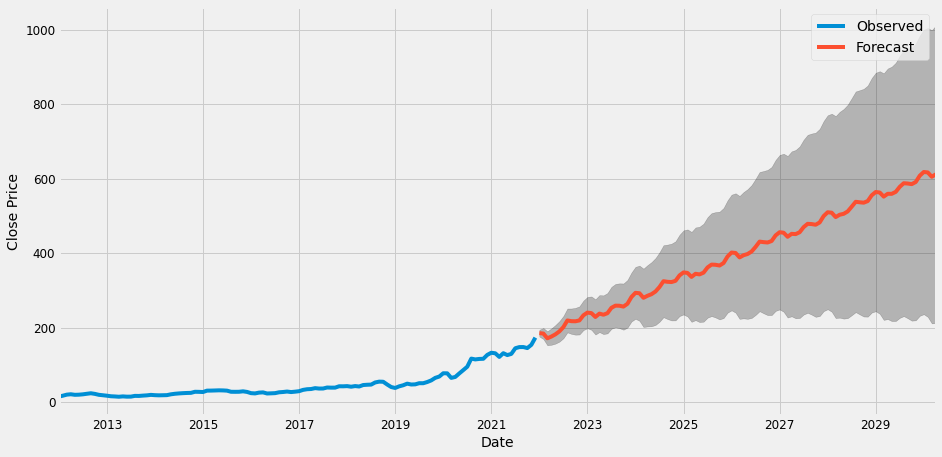

In [26]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')

plt.legend()
plt.show()

In [24]:
Our model clearly captured close price seasonality. 
As we forecast further out into the future, it is natural for us to become less confident in our values. 
This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

SyntaxError: invalid syntax (<ipython-input-24-856a9b535a6a>, line 1)